In [1]:
import netCDF4 as nc
from pathlib import Path
import glob

#Array 
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import dask

#Visualize
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import cmcrameri.cm as cmc # batlow colourmap

#large data visualization
import datashader as ds
from datashader import transfer_functions as tf, reductions as rd

# Analyse
from scipy import signal
from scipy.interpolate import BSpline

# Other
#import tqdm
import seaborn as sns

In [1]:
# IMPORT MAIN MODULE AND SUB-MODULES
import CL61_module
from CL61_module import module as mCL61
from CL61_module import classification

In [3]:
import importlib  # To reload files
importlib.reload(mCL61)
importlib.reload(classification)

<module 'CL61_module.classification' from 'c:\\Users\\gezas\\kDrive\\SIE-Project\\CL61\\CL61_module\\classification.py'>

In [3]:
plt.style.use('bmh')

COLOR_MAP = 'cmc.batlow'

NameError: name 'plt' is not defined

# Open dataset

In [2]:
februar_cl61 = mCL61.CL61Processor(folder_path='../CL61/Data', specific_filename='temp_20230204.nc')
june = mCL61.CL61Processor(folder_path='../CL61/Data', specific_filename='temp_1d_test.nc')

In [3]:
februar_cl61.mask_noise(window_size=[10,10])

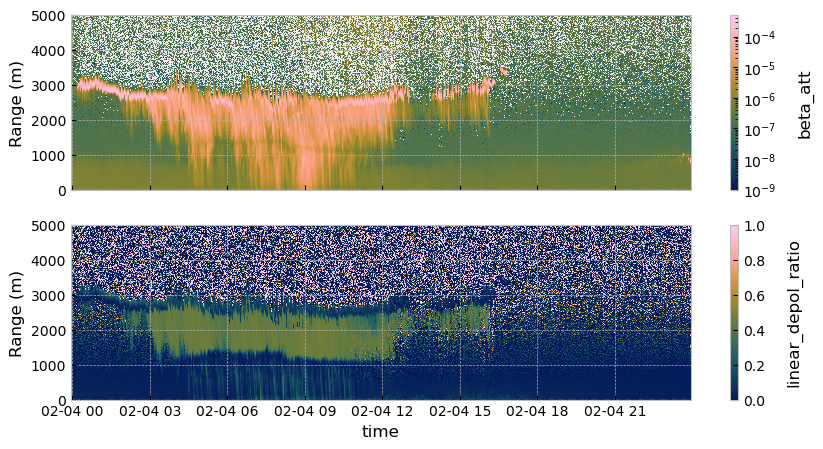

In [4]:
februar_cl61.visualize_data(plot_type='colormesh')

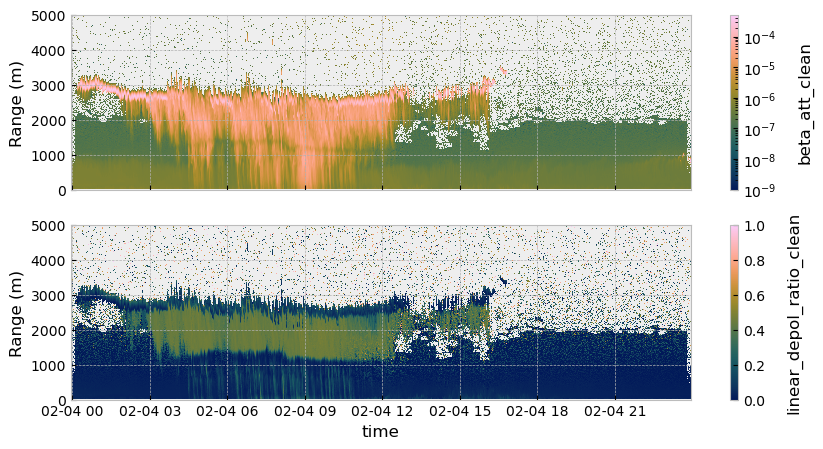

In [5]:
februar_cl61.visualize_data(plot_type='colormesh', varriable_names=['beta_att_clean', 'linear_depol_ratio_clean'])

In [7]:
februar_cl61.dataset

<xarray.Dataset>
Dimensions:                            (time: 1440, layer: 5, range: 3276)
Coordinates:
  * time                               (time) datetime64[ns] 2023-02-03T23:57...
  * range                              (range) float64 0.0 4.8 ... 1.572e+04
  * layer                              (layer) float64 1.0 2.0 3.0 4.0 5.0
    longitude                          float64 ...
    latitude                           float64 ...
Data variables: (12/19)
    cloud_base_heights                 (time, layer) float64 ...
    vertical_visibility                (time) float64 ...
    p_pol                              (time, range) float32 ...
    x_pol                              (time, range) float32 ...
    beta_att                           (time, range) float32 2.007e-06 ... 8....
    linear_depol_ratio                 (time, range) float32 0.1223 ... -0.1736
    ...                                 ...
    sky_condition_cloud_layer_covers   (time, layer) float32 ...
    sky_condition_cloud_layer_heights  (time, layer) float64 ...
    beta_att_clean                     (time, range) float32 2.007e-06 ... 8....
    linear_depol_ratio_clean           (time, range) float32 0.1223 ... -0.1736
    noise_mask                         (time, range) bool True True ... True
    to_interpolate_mask                (time, range) bool False False ... False
Attributes:
    title:                                         CL61D, CL61 with Depolariz...
    institution:                                   
    source:                                        CL61EERL
    conventions:                                   CF-1.8
    schema_version:                                1.2
    sw_version:                                    1.1.10
    history:                                       
    comment:                                       
    unit:                                          m
    temporal span of this file in minutes:         5.0
    time between consecutive profiles in seconds:  60

In [50]:
window_size = [5,5] # time x range
rolling = februar_cl61.dataset['beta_att'].rolling(time=window_size[0], range=window_size[1]).construct({'time':"time_window", 'range':'range_window'})

In [54]:
februar_cl61.dataset['linear_depol_ratio'].notnull().all()

<xarray.DataArray 'linear_depol_ratio' ()>
array(True)
Coordinates:
    longitude  float64 7.361
    latitude   float64 46.22

In [57]:
# Apply the rolling window operation
window_size = [5,5]
window_element_numbers = window_size[0]*window_size[1]
in_range = np.logical_and(februar_cl61.dataset['linear_depol_ratio'] > 0, februar_cl61.dataset['linear_depol_ratio'] < 1).astype(int)
in_range_window_sum = in_range.rolling(time=window_size[0], range = window_size[1], center=True, min_periods=window_size[0]//2*window_size[1]//2).reduce(np.sum)
mask_in_range = in_range_window_sum==window_element_numbers
xr.where(mask_in_range, februar_cl61.dataset['linear_depol_ratio'], np.nan).plot.pcolormesh(x='time', y='range', cmap=COLOR_MAP)

<xarray.DataArray 'linear_depol_ratio' (time: 1440, range: 3276)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, 25., ...,  4., nan, nan],
       ...,
       [nan, nan, 25., ..., 12., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time       (time) datetime64[ns] 2023-02-03T23:57:10.712999936 ... 2023-0...
  * range      (range) float64 0.0 4.8 9.6 ... 1.571e+04 1.572e+04 1.572e+04
    longitude  float64 7.361
    latitude   float64 46.22

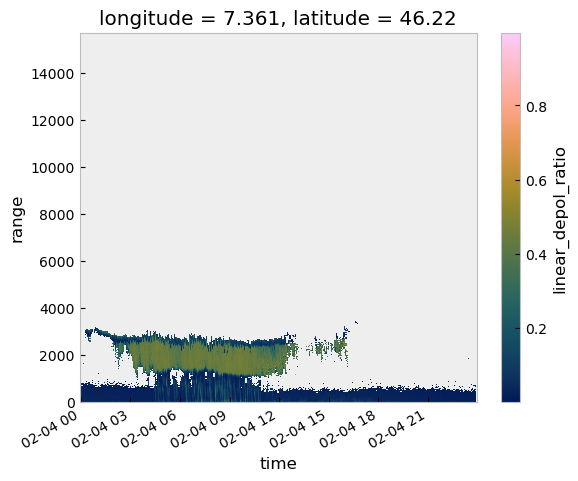

In [60]:
xr.where(mask_in_range, februar_cl61.dataset['linear_depol_ratio'], np.nan).plot.pcolormesh(x='time', y='range', cmap=COLOR_MAP)

In [18]:
out_range = (februar_cl61.dataset['linear_depol_ratio']<0).astype(int)
xr_3 = (februar_cl61.dataset['linear_depol_ratio']>0).astype(int)
xr_2+xr_3
#(xr_2 + xr_3).rolling(time=window_size[0], range=window_size[1], center=True).construct({'time':"time_window", 'range':'range_window'})

<xarray.DataArray 'linear_depol_ratio' (time: 1440, range: 3276)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * time       (time) datetime64[ns] 2023-02-03T23:57:10.712999936 ... 2023-0...
  * range      (range) float64 0.0 4.8 9.6 ... 1.571e+04 1.572e+04 1.572e+04
    longitude  float64 7.361
    latitude   float64 46.22